In [21]:
import numpy as np # linear algebra
import pandas as pd # rawprocessing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [22]:
# import requirement libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
# import plotly.graph_objects as go

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import warnings
warnings.filterwarnings("ignore")

from os.path import dirname, abspath
import sys, os
d = dirname(os.path.abspath(''))
sys.path.append(d)
# from implicitdl import ImplicitModel, ImplicitModelLoRA, ImplicitFunctionInf, ImplicitFunctionTriu, ImplicitRNNCell, ImplicitRNNCellLoRA
from implicitdl import *

In [23]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda:2") 
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
torch.set_default_device(device)
generator = torch.Generator(device=device)

GPU is available


In [24]:
import numpy as np
import matplotlib.pyplot as plt

generate_data = 1
level = 5

input_dim_gt = level*3
hidden_dim_gt = level*5
output_dim_gt = level*2

np.random.seed(1)
torch.manual_seed(1)

den = 5
Agt = nn.Parameter(torch.randn(hidden_dim_gt, hidden_dim_gt)/den)
Bgt = nn.Parameter(torch.randn(hidden_dim_gt, input_dim_gt))
Cgt = nn.Parameter(torch.randn(output_dim_gt, hidden_dim_gt))
Dgt = nn.Parameter(torch.randn(output_dim_gt, input_dim_gt))
gt_model = ImplicitModel(hidden_dim_gt, input_dim_gt, output_dim_gt, f=ImplicitFunctionInf).eval()
# initialize the model with the random matrices
gt_model.A = Agt
gt_model.B = Bgt
gt_model.C = Cgt
gt_model.D = Dgt

n_samples = level*10000
n_samples_val = 200

if generate_data:
    # generate data for training and validation using gt_mode
    x_values = torch.randn(n_samples, input_dim_gt)*10
    y_values = gt_model(x_values)
    x_values_val = torch.randn(n_samples_val, input_dim_gt)*10
    y_values_val = gt_model(x_values_val)
    # save the data to npz file
    np.savez(f'./kaggle/input/synthetic_fp_data_h{hidden_dim_gt}.npz', x_values=x_values.detach().cpu(), y_values=y_values.detach().cpu(), x_values_val=x_values_val.detach().cpu(), y_values_val=y_values_val.detach().cpu())
    # print(x_values[:5], y_values[:5])

# load from the npz file
data = np.load(f'./kaggle/input/synthetic_fp_data_h{hidden_dim_gt}.npz')
x_values = torch.tensor(data['x_values']).to(device)
y_values = torch.tensor(data['y_values']).to(device)
# print(x_values[:5], y_values[:5])
x_values_val = torch.tensor(data['x_values_val']).to(device)
y_values_val = torch.tensor(data['y_values_val']).to(device)
# into data_loader
training_set = TensorDataset(x_values, y_values)
validation_set = TensorDataset(x_values_val, y_values_val)

# Model

In [25]:
from typing import Optional

   
def fuse_parameters(model):
    """Move model parameters to a contiguous tensor, and return that tensor."""
    n = sum(p.numel() for p in model.parameters())
    params = torch.zeros(n)
    i = 0
    for p in model.parameters():
        params_slice = params[i:i + p.numel()]
        params_slice.copy_(p.flatten())
        p.data = params_slice.view(p.shape)
        i += p.numel()
    return params

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, act):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size, bias=False),
            act(),
            nn.Linear(hidden_size, hidden_size, bias=False),
            act(),
            # nn.Linear(hidden_size, hidden_size, bias=False),
            # act(),
            nn.Linear(hidden_size, output_dim, bias=False),
        )
    def forward(self, x):
        x1 = x.flatten(1,-1)
        return self.model(x1)

# Define and train Model

In [26]:
def train_one_epoch(model, training_loader, optimizer, scheduler, loss_fn):
    running_loss = 0.
    last_loss = 0.
    for t, data in enumerate(training_loader):
        x_train, y_train = data
        optimizer.zero_grad()
        y_train_pred = model(x_train)
        loss = loss_fn(y_train_pred, y_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (t % 10 == 9):
            last_loss = running_loss / 10 # loss per batch
            running_loss = 0.
    return last_loss

def plot_hist(y_axis, xlabel, ylabel, title, x_axis=None, log=False):
    plt.figure()
    if (x_axis is None):
        x_axis = range(len(y_axis))
    if log:
        plt.semilogy(x_axis, y_axis)
    else:
        plt.plot(x_axis, y_axis)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()


def evaluate_model(model, validation_loader):
    # Disable gradient computation and reduce memory consumption.
    running_vloss = 0.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels).item()
            running_vloss += vloss
    avg_vloss = running_vloss / (i + 1)
    return avg_vloss

In [27]:
make_imp = lambda: ImplicitModel(hidden_dim_gt, input_dim_gt, output_dim_gt, f=ImplicitFunctionInf, no_D=False, bias=False)
make_mlp = lambda: MLP(input_dim_gt, 14, output_dim_gt, act=nn.ReLU)

In [28]:
batch_size = 512
EPOCHS = 90
RUNS = 1

torch.manual_seed(4)
# format data for training to dataloader
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, generator=generator)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, generator=generator)
loss_fn = torch.nn.MSELoss()
generator = torch.Generator(device=device)

best_vloss = 1_000_000.
for run_idx in range(RUNS):
    # model, lr = make_mlp().to(device), 0.01; #torch.nn.init.normal_(fuse_parameters(model))
    model, lr = make_imp().to(device), 0.07; torch.nn.init.normal_(fuse_parameters(model), mean=0, std=0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=0.99)
    # print(model)
    if run_idx == 0:
        print(f'model size: {sum(p.numel() for p in model.parameters())} parameters')
    
    avg_vloss_all = []
    avg_loss_all = []
    up_count = 0
    for epoch in range(EPOCHS):
        model.train(True)    
        avg_loss = train_one_epoch(model, training_loader, optimizer, scheduler, loss_fn)
        avg_loss_all.append(avg_loss)
        scheduler.step()

        model.eval()
        avg_vloss = evaluate_model(model, validation_loader)
        avg_vloss_all.append(avg_vloss)
        print(f'Epoch {epoch} loss: {avg_loss}, val loss: {avg_vloss}')

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            best_model = model
            up_count = 0
        else:
            up_count += 1
        
        if up_count > 15:
            break
    print(f'Run {run_idx} best val loss: {best_vloss}')
# print(f'r2 (higher better):    {np.mean(r2s):.2f} +- {np.std(r2s):.2f}')
# print(f'MAPE (smaller better): {np.mean(mapes):.2f} +- {np.std(mapes):.2f}')
# ############# can calibrate size of RNN to compartible with imp_rnn
# best_r2_index = np.argmax(r2s)
# best_mape_index = np.argmin(mapes)

# print(f'Best r2 (higher better):    {r2s[best_r2_index]:.2f} at iteration {best_r2_index}')
# print(f'Best MAPE (smaller better): {mapes[best_mape_index]:.2f} at iteration {best_mape_index}')

model size: 1400 parameters


Epoch 0 loss: 800.9536010742188, val loss: 613.0016479492188
Epoch 1 loss: 230.84110565185546, val loss: 189.4469451904297
Epoch 2 loss: 105.55997009277344, val loss: 94.78427124023438
Epoch 3 loss: 78.24407653808593, val loss: 71.75308227539062
Epoch 4 loss: 70.94439544677735, val loss: 68.13319396972656
Epoch 5 loss: 54.801845169067384, val loss: 50.18779754638672
Epoch 6 loss: 46.31356353759766, val loss: 39.826019287109375
Epoch 7 loss: 33.326507568359375, val loss: 26.288938522338867
Epoch 8 loss: 19.156935501098634, val loss: 16.784284591674805
Epoch 9 loss: 4.726262331008911, val loss: 3.708618402481079
Epoch 10 loss: 2.555318093299866, val loss: 2.121724843978882
Epoch 11 loss: 1.7712716698646545, val loss: 1.535872220993042
Epoch 12 loss: 1.216999626159668, val loss: 1.050929307937622
Epoch 13 loss: 0.8424838960170746, val loss: 0.7608981132507324
Epoch 14 loss: 0.5864245772361756, val loss: 0.5273020267486572
Epoch 15 loss: 0.40252805054187774, val loss: 0.382553368806839
Epo

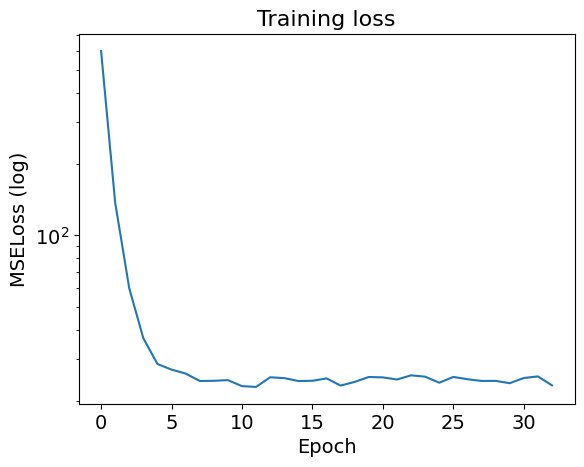

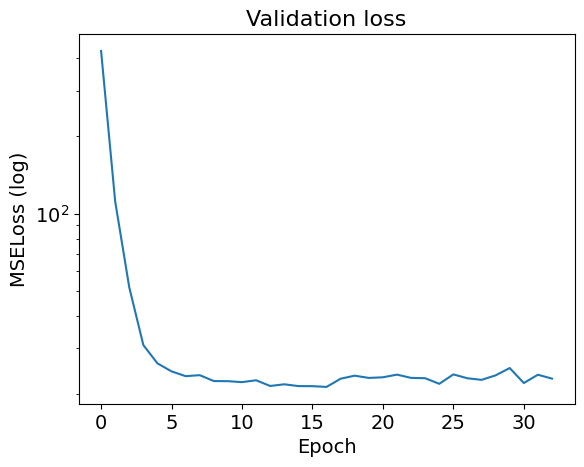

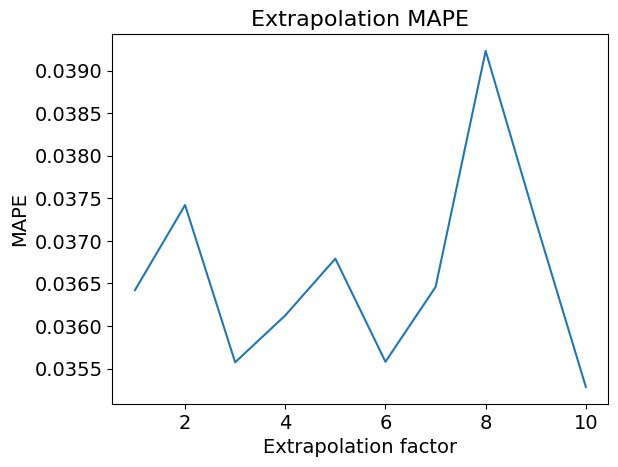

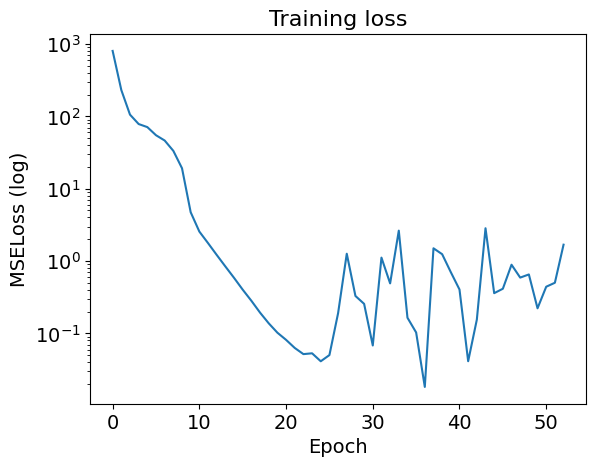

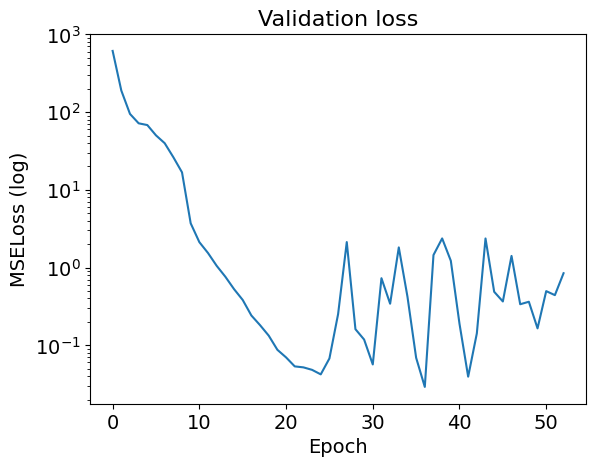

In [29]:
plot_hist(avg_loss_all, 'Epoch', 'MSELoss (log)', 'Training loss', log=True)
plot_hist(avg_vloss_all, 'Epoch', 'MSELoss (log)', 'Validation loss', log=True)

In [30]:
if isinstance(best_model, ImplicitModel):
    # compare model.A with gt_model.A
    print("A", best_model.A.cpu().detach().numpy())
    print("Agt",gt_model.A.cpu().detach().numpy())
    print("D",best_model.D.cpu().detach().numpy())
    print("Dgt",gt_model.D.cpu().detach().numpy())

    print((best_model.A - gt_model.A).norm().item())
    print((best_model.B - gt_model.B).norm().item())
    print((best_model.C - gt_model.C).norm().item())
    print((best_model.D - gt_model.D).norm().item())


A [[ 0.27852395 -0.44479728 -1.1544709  -1.1043816  -2.2090755   0.06115556
   0.4403466  -1.977642   -0.7865632   0.4982169  -0.44509786 -1.8759595
   1.3403828   0.85722613 -2.9368515   2.9481397   2.3227015  -1.5603324
  -2.8752654   0.15155262 -1.9231323  -0.63926333 -2.0058346  -2.9848049
  -0.22201847]
 [-1.3961545   0.36318025  0.86331666  0.00952217 -0.38457632 -3.0348492
   0.33199945 -0.93784875  1.1310624   0.6347017  -2.137269    2.598865
  -3.558524   -0.9422212  -0.3490303  -1.3353566  -1.1976328   0.37757465
  -0.21126159  0.830375    2.4943311  -0.12633291 -0.00681762  4.3736997
  -0.6905763 ]
 [ 0.07413939  0.21215287  0.77378714  0.08593684 -0.78265274  0.7677576
   0.25628823 -1.2246411   1.9126965   2.1099877  -0.56469697 -1.7632898
   0.01612607 -2.1331158  -1.0779742   0.7091415  -2.8142715  -0.61710185
  -1.51604    -0.08987338 -3.4318995  -1.4860096  -0.9043708  -1.9841813
  -1.2963027 ]
 [-0.8697753  -1.957591   -0.2650198   0.07355703 -1.0389829   1.2710671
  

In [31]:
x_test = torch.randn(1, input_dim_gt)*10000
# x_test = x_values[np.random.randint(0, n_samples)].unsqueeze(0)
y_test = gt_model(x_test)
y_test_pred = best_model(x_test)
print(f'x_test: {x_test.detach().cpu().numpy()}')
print(f'y_test: {y_test.detach().cpu().numpy()}')
print(f'y_test_pred: {y_test_pred.detach().cpu().numpy()}')

running_mape = 0.
with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = best_model(vinputs)
        mape = ((voutputs - vlabels).norm(dim=1) / vlabels.norm(dim=1)).mean()
        running_mape += mape
avg_mape = running_mape / (i + 1)
print(f'level: {level}, avg mape: {avg_mape}')
print(gt_model.A[-1,0])

x_test: [[  2404.0063    5232.482   -10822.7705   14202.13     -5470.9214
    2840.9546   -4728.072   -23734.236   -10453.638    -5194.255
    4702.329      136.99686   4364.5356    -308.54456  -9271.1875 ]]
y_test: [[ -14616.555  -21113.48   -22309.79  -121519.34     8551.469  -32073.133
  -123060.8     94364.14   -48116.36   -78710.16 ]]
y_test_pred: [[ -15033.518  -21657.793  -22186.102 -120200.78    10100.095  -33235.96
  -122550.5     95268.12   -47645.25   -78676.36 ]]
level: 5, avg mape: 0.00693767424672842
tensor(-0.0593, device='cuda:2', grad_fn=<SelectBackward0>)


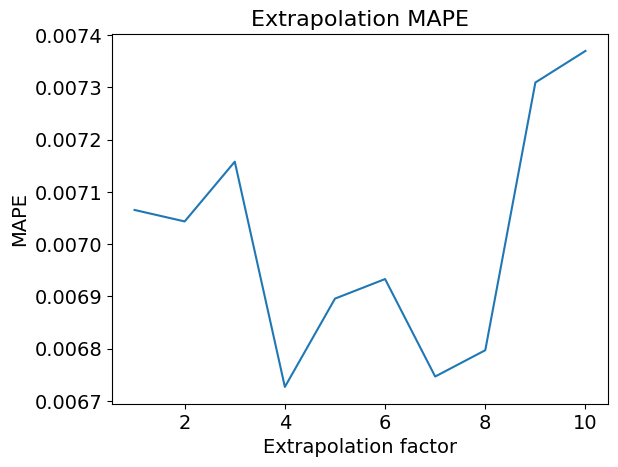

In [32]:
extrap_level = 1
extrap_max = 10
mapes = []

with torch.no_grad():
    for ood_level in range(extrap_max):
        x_ood = torch.randn(n_samples_val, input_dim_gt)*10**extrap_level
        y_ood = gt_model(x_ood)
        y_ood_pred = best_model(x_ood)
        mape = ((y_ood - y_ood_pred).norm(dim=1) / y_ood_pred.norm(dim=1)).mean()
        mapes.append(mape.cpu())

# figure for mapes
plot_hist(mapes, 'Extrapolation factor', 'MAPE', 'Extrapolation MAPE', x_axis=range(1,extrap_max+1))
